# Social Computing - Summer 2019
# Exercise 4 - Social Tie Strength

In this exercise, you are going to predict tie strength in a social network using the method explained in [1]. According to Mark Granovetter, the strength of a tie between two persons is a combination of the amount of time, the emotional intensity, the intimacy and the reciprocal services which characterize it. Using variables that describe these categories, we want to find that combination in order to predict the strength of ties not previously known.<br>
An important prerequisite to this exercise is understanding the basic concept of linear regression models. As mentioned in the lecture, a recommended reading is chapter 3 of [2].

[1] E. Gilbert and K. Karahalios: _Predicting Tie Strength With Social Media_. Proceedings of the SIGCHI Conference on Human Factors in Computing Systems. ACM, 2009.<br>
[2] C. Bishop: _Pattern Recognition and Machine Learning_. 2006.

### Tie Strength Prediction

In social network analysis, the tie strength between to people measures how strong their relationship is. The paper above describes the procedure of deriving available information (different variables) about a connection between two persons from an online social network and using it in order to discover how close they are. The ultimate goal is to build a model using the given information, finding out which variables account most for the tie strength and using that model later on to predict social tie strength when only the predictive (or explanatory) variables are available. Before being able to predict anything, we need to find out whether the given variables are suitable for prediction in the first place. This can be done via creating and evaluting a **multiple linear regression model**. 'Multiple' here refers to more than one predictive variables in an regression model.<br>
In the paper mentioned above, 67 variables where used in the linear model to predict the tie strength. In our simplified model, we are going to use only 10 predictive variables which are:

1. Number of friends (I)
2. Friends' number of friends (I)
3. Days since last communication (I)
4. Appearance together in photos (I)
5. Wall intimacy words (I)
6. Inbox intimacy words (I)
7. Days since first communication (D)
8. Number of mutual friends (S)
9. Age distance (SD)
10. Educational distance (SD)<p>
    
With (I) being **intimacy** variables, (D) **duration** variables, (S) **structural** variables and (SD) **social distance** variables.

We are going to use a simplified form of the paper's linear model:
$$y_i = \alpha + \beta X_i + \epsilon_i$$

where $y_i$ is the dependent variable (also referred to as target value, which is the tie strength in our case) of the $i$-th friend of a person. $X_i$ is the predictive vector, containing the (predictive) variables listed above. $\alpha$ and $\beta$ are the model's parameters, where $\alpha$ is the intercept/bias, $\beta$ the coefficient vector containing coefficients for each predictive variable, and $\epsilon$ the prediction error. The regression problem boils down to calculating the model's parameters given a certain ground truth; meaning that for some connections, the tie strength has to be already known for building the model. That way, the unknown tie strengths can be predicted using the regression model by simply inserting the values in the vector.

### Problem Overview

The input to your Python program is a directed social network _SocialGraph.gml_. The GML format is human-readable and similar to the GraphML format used in exercise 2. Just open the file in your text editor and examine the nodes' and edges' attributes. Using igraph again, you can convert it into a Graph object.

In practice, the ground truth (tie strength) is usually retrieved by participant's answers to surveys how strong their relationship is with another person - this is why the graph is directed, two people might have varying views. The ground truth is available in the file. About 70% of the edges have valid values for the `tieStrength` variable, which should be used for training. For about 30% of the edges, the variable is set to -1 (equivalent to unknown). These represent the testing set for which the tie strength should be predicted using the linear regression model later. But first, that model needs to be computed and checked for its goodness of fit.

## Imports and Visualization
At first, needed libraries and the graph have to be imported. The social graph is visualized in order to get an idea what the network actually looks like.

If you need information on how to work with igraph's graph structure, you can look it up in the [igraph manual](https://igraph.org/python/doc/igraph-module.html). For the purpose of working with an larger datasets, you need to save the variables in a suitable data format. In our case, the pandas library is a good choice. For more information on the library, see the [pandas manual](https://pandas.pydata.org/pandas-docs/version/0.19.2) and its [tutorial](https://pandas.pydata.org/pandas-docs/version/0.19.2/10min.html) to pandas dataframes. - pay attention to the version there if you installed the libraries manually. Apart from that, we will be working with the [statsmodels module](https://www.statsmodels.org/stable/index.html) for the regression model.

In [3]:
from statsmodels.api import add_constant
import igraph as ig, numpy as np, pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt

g = ig.Graph.Read_GML('SocialGraph.gml')

# Formatting the graph
visual_style = {}
visual_style['vertex_size'] = 10
visual_style['vertex_label'] = g.vs['id']
visual_style['bbox'] = (700, 700)
visual_style['margin'] = 50

ig.plot(g, **visual_style)

## Problem 4.1: Completing The Social Graph

If you inspected the _SocialGraph.gml_ file, you may have observed that some of the ten predictive variables are already present as node or edge attributes while others are not. In order to later compute the linear model with these ten predictive variables, the missing values are needed. Luckliy, they can be calculated from the already existing ones. **Therefore, your first task is to complete the social graph by calculating all the missing nodes/edges attributes.** Save the vectors with known tie strength as training data in a seperate dataframe as the unknown ones (since those are used for prediction later). Output the first ten entries of the training table.

**Notes:**
* It is recommended to first work with lists when computing the missing variables and converting it into a pandas dataframe afterwards. Look up the function `Dataframe()` in the manual for creating a one.
* Use `head(n)` on a dataframe to output the first n entries.
* Pay attention to the data types of the features.

In [4]:
# Calculates the missing values for current edge e of graph g
def calculate_missing_variables(g, e):
    # Source and target nodes for current edge
    src = g.vs[e.source]
    tgt = g.vs[e.target]
    
    # TODO: Calculate the other variables from existing ones
    
    # Vertes variables
    ##Number of friends
    nb_src = len(g.neighbors(vertex=e.source))
    nb_tgt = len(g.neighbors(vertex=e.target))
    nb = nb_src + nb_tgt
    
    ##Friends's number of friends
    nb_nb_src = 0
    nb_nb_tgt = 0
    for v in g.neighbors(vertex=e.source):
        nb_nb_src += len(g.neighbors(vertex=v)) 
    for v in g.neighbors(vertex=e.target):
        nb_nb_tgt += len(g.neighbors(vertex=v)) 
    nb_nb = nb_nb_src + nb_nb_tgt
    
    ##Age distance
    age_dist = np.abs(src["age"] - tgt["age"])
    
    ##Educational distance
    edu_diff = np.abs(src["numAcDegrees"] - tgt["numAcDegrees"])
    
    # Edge variables
    ## Number of mutual friends
    e_mutual = 0
    for i in g.neighbors(vertex=e.source):
        for j in g.neighbors(vertex=e.target):
            if i == j:
                e_mutual += 1
    
    # TODO: Create row for dataframe
    #row = [[nb_src,nb_tgt],[nb_nb_src,nb_nb_tgt],e["lastComm"],e["photosTogether"],e["wallIntimWords"],e["inboxIntimWords"], 
    #       e["firstComm"],e_mutual, age_dist,edu_diff,e["tieStrength"]]
    row = [nb,nb_nb,e["lastComm"],e["photosTogether"],e["wallIntimWords"],e["inboxIntimWords"], 
           e["firstComm"],e_mutual, age_dist,edu_diff,e["tieStrength"]]
    
    return row


# Training and prediction lists
train_list = []
pred_list = []
cols = ['#Friends', 'Friends\' #Friends', '#Days Since Last Comm', '#Photos', '#Wall Intimacy Words', 
        '#Inbox Intimacy Words', '#Days Since First Comm','#Mutual Friends', 'Age Dist', 'Educational Diff', 'Tie Strength']

# Calculate rows (one for each edge) and add them to tables
for e in g.es:
    row = calculate_missing_variables(g, e)
    
    # TODO: Append to respective list
    if e["tieStrength"] >= 0:
        train_list.append(row)
    else:
        pred_list.append(row)
        
# TODO: Create training and prediction tables
train_table = pd.DataFrame(train_list)
pred_table = pd.DataFrame(pred_list)

train_table.columns = [cols]
pred_table.columns = [cols]

print(train_table.head(10))

   #Friends  Friends' #Friends  #Days Since Last Comm  #Photos  \
0        74               4204                  173.0     12.0   
1        92               4348                  168.0     13.0   
2        46               2616                  239.0      5.0   
3        50               2624                  201.0      9.0   
4        72               3344                  169.0     12.0   
5        44               2400                  142.0     17.0   
6        66               4364                  178.0     11.0   
7       104               7012                  135.0     17.0   
8       116               8440                  173.0     13.0   
9       142               9580                  116.0     21.0   

   #Wall Intimacy Words  #Inbox Intimacy Words  #Days Since First Comm  \
0                  48.0                  243.0                  1726.0   
1                  57.0                  334.0                  1709.0   
2                  13.0                   88.0     

## Problem 4.2: Prediction of Tie Strengths
Now that the social graph is completed, the multiple linear regression model presented above can be computed. Remember that the goal is to find a model that fits the data well and has explanatory power over the tie strength. That way, further tie strengths that are unknown can be predicted using the regression model. To ensure that the model is meaningful, it needs to be evaluated and examined for its goodness of fit. You will start with preparing the data in the tasks, followed by the just mentioned procedure.

### Task 1: Log-Transformation
In data analysis, transformation is the replacement of a variable by a function of that variable. For example, replacing a variable $x$ by its square root $\sqrt{x}$ or its logarithm $\log{x}$. In a stronger sense, it means a replacement that changes the shape of a distribution or relationship. There are many reasons for transformations. The following list are a few of them but it is not comprehensive:

1. Convenience
2. Reducing skewness
3. Equal spreads
4. Linear relationships
5. Additive relationships

If you are looking at just one explanatory variable, points 1, 2 and 3 are relevant. But concerning two or more variables, points 4 and 5 are more important. However, transformations that achieve 4 and 5 very often fulfill 2 and 3 as well. In our case, a logarithm transformation on the predictibe variables will be used.

With the help of numpy's `log` function, **apply the log-transformation on each feature vector for the training table (but not the tie strength)**. Pay attention to the fact that $\log{0}$ is not defined, a small number (e.g. 0.000001) should be added before the transformation! Again, output the first ten entries of your dataframe.

In [5]:
train_table_log = pd.DataFrame(columns=cols)

# TODO: Fill the log training table and apply log-transformation on predictive variables
train_table_log['#Friends']=train_table['#Friends'].apply(lambda x:np.log(np.array(x)+1e-6))
train_table_log['Friends\' #Friends']=train_table['Friends\' #Friends'].apply(lambda x:np.log(np.array(x)+1e-6))
train_table_log['#Days Since Last Comm']=train_table['#Days Since Last Comm'].apply(lambda x:np.log(np.array(x)+1e-6))
train_table_log['#Photos']=train_table['#Photos'].apply(lambda x:np.log(np.array(x)+1e-6))
train_table_log['#Wall Intimacy Words']=train_table['#Wall Intimacy Words'].apply(lambda x:np.log(np.array(x)+1e-6))
train_table_log['#Inbox Intimacy Words']=train_table['#Inbox Intimacy Words'].apply(lambda x:np.log(np.array(x)+1e-6))
train_table_log['#Days Since First Comm']=train_table['#Days Since First Comm'].apply(lambda x:np.log(np.array(x)+1e-6))
train_table_log['#Mutual Friends']=train_table['#Mutual Friends'].apply(lambda x:np.log(np.array(x)+1e-6))
train_table_log['Age Dist']=train_table['Age Dist'].apply(lambda x:np.log(np.array(x)+1e-6))
train_table_log['Educational Diff']=train_table['Educational Diff'].apply(lambda x:np.log(np.array(x)+1e-6))
train_table_log['Tie Strength']=train_table['Tie Strength']

print(train_table_log.head(10))

   #Friends  Friends' #Friends  #Days Since Last Comm   #Photos  \
0  4.304065           8.343792               5.153292  2.484907   
1  4.521789           8.377471               5.123964  2.564949   
2  3.828641           7.869402               5.476464  1.609438   
3  3.912023           7.872455               5.303305  2.197225   
4  4.276666           8.114923               5.129899  2.484907   
5  3.784190           7.783224               4.955827  2.833213   
6  4.189655           8.381144               5.181784  2.397895   
7  4.644391           8.855378               4.905275  2.833213   
8  4.753590           9.040738               5.153292  2.564949   
9  4.955827           9.167433               4.753590  3.044522   

   #Wall Intimacy Words  #Inbox Intimacy Words  #Days Since First Comm  \
0              3.871201               5.493061                7.453562   
1              4.043051               5.811141                7.443664   
2              2.564949               4.

### Task 2: Building The Regression Model
Finally, the regression can be applied on the dataframe. For this purpose, split the dataframe into the target and predictive variables into variables $y$ and $X$. A constant term, corresponding to the bias $\alpha$ in the mathematical definition above, needs to be added to the regression before its computation. It represents the target value when all explanatory variables are zero - think of it as a baseline. If there was no intercept, the model would be less meaningful. You can add the intercept with `add_constant(X)`.

Now apply a multiple linear regression on the training table, the statsmodels functions `OLS()` and `fit()` will help you with that. Output the summary with the help of `summary()`. **State what the coefficients tell you about the influence of the respective features for predicting the tie strength. Which kind of variables (I, D, S, SD) have the most influence? Does it match the findings of the paper referenced in [1]?** Note that the coefficients do not need to be high or within the [-1,1] range, but can be. Take into account other statistics for your evaluations. **For example, what does the (adjusted) R-squared value say about the prediction?** Do not write more than 7 sentences overall.

In [6]:
print(np.array(train_table_log).shape)
# Split dataframe in target and predictive variables
y = train_table_log['Tie Strength']
X = train_table_log.ix[0:3525,['#Friends', 'Friends\' #Friends', '#Days Since Last Comm', '#Photos', '#Wall Intimacy Words', 
        '#Inbox Intimacy Words', '#Days Since First Comm','#Mutual Friends', 'Age Dist', 'Educational Diff']]
print(np.array(y))
print(type(y))
X = sm.add_constant(X)
print(np.asarray(X))

(3526, 11)
[0.24922391 0.26296461 0.10209932 ... 0.25981861 0.1522041  0.30274457]
<class 'pandas.core.series.Series'>
[[ 1.00000000e+00  4.30406511e+00  8.34379173e+00 ...  3.46573593e+00
   2.19722469e+00  6.93147681e-01]
 [ 1.00000000e+00  4.52178859e+00  8.37747125e+00 ...  3.58351897e+00
   1.60943811e+00  6.93147681e-01]
 [ 1.00000000e+00  3.82864142e+00  7.86940171e+00 ...  2.48490673e+00
   2.39789536e+00 -1.38155106e+01]
 ...
 [ 1.00000000e+00  3.17805387e+00  6.87935581e+00 ...  2.48490673e+00
   3.61091794e+00  6.93147681e-01]
 [ 1.00000000e+00  3.46573593e+00  7.35500192e+00 ...  2.99573232e+00
   2.07944167e+00  9.99999500e-07]
 [ 1.00000000e+00  4.78749175e+00  9.04829192e+00 ...  2.07944167e+00
   3.76120014e+00 -1.38155106e+01]]


In [7]:
# Split dataframe in target and predictive variables
y = train_table_log['Tie Strength']
X = train_table_log.ix[0:3525,['#Friends', 'Friends\' #Friends', '#Days Since Last Comm', '#Photos', '#Wall Intimacy Words', 
        '#Inbox Intimacy Words', '#Days Since First Comm','#Mutual Friends', 'Age Dist', 'Educational Diff']]

## TODO: Add the intercept
X = sm.add_constant(X)
#print('xxx',X)
#print('y',type(y))
# TODO: Apply OLS regression
model = sm.OLS(y,X.astype(float))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Tie Strength   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1052.
Date:                Sun, 30 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:19:48   Log-Likelihood:                 4405.2
No. Observations:                3526   AIC:                            -8788.
Df Residuals:                    3515   BIC:                            -8721.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

The coefficients of each explanatory variable reflect the strength and type of relationship between the explanatory variable and the dependent variable. 

When the sign associated with the coefficient is negative, the relationship is negative (eg, the more days since the last communication, the weaker the social tie strength). 

When the sign is positive, the relationship is positive (for example, the more friends there are, the stronger the social tie strength is).

The influence of the coefficients for predicting the tie strength: intimacy variables(0.2229+0.0644+0.0209+0.0013+0.0062+0.0342) > duration variables(0.0303) > social distance variables(0.0083+0.0043) > structural variables(0.0020).

It matches the findings of the paper referenced in [1].

The T test is used to assess whether or not an explanatory variable is statistically significant. The null hypothesis is that the coefficient is, for all intents and purposes, equal to zero (and consequently is NOT helping the model). 

When the probability is very small, the chance of the coefficient being essentially zero is also small. 

DF Residuals represents degrees of freedom of the residuals(Number of observations - number of parameters).

R-squared is the coefficient of determination, which measures of how well the regression line approximates the real data points.The R-squared of our model is 0.75, which means the regression line approximates the real data well.

Adjusted R-squared is the above value adjusted based on the number of observations and the degrees-of-freedom of the residuals. The adjusted R-squared of our model is 0.749, which means the regression line approximates the real data well.



### Task 3: Prediction of Tie Strengths
As a last step, the missing values (marked with -1) for some tie strength entries should be predicted using the before computed regression model. **Use the regression model to predict the missing tie strength values.** Statsmodels will be of help with that. Remember that we transformed the training data with a log-transform and added an intercept, so this needs to be done here as well. Output the first ten entries.
    
**Are the predictions in line with the observations above? Pick a few entries to back up your observations.** If you would like to talk about other than the first ten entries, you can query a pandas dataframe similar to SQL. More information on how to do this is available in the [pandas documenation](https://pandas.pydata.org/pandas-docs/version/0.19.2/comparison_with_sql.html). Do not write more than 3 sentences.

**Note:** Values outside the realistic range in the interval of (0,1) for the tie strength might exist because of very low/high values for some predictive variables in the dataset. You can consider them as almost 0/1.

In [12]:
# Split dataframe
pred_table_log = pd.DataFrame(columns=cols[:-1])

# TODO: Apply log-transform on prediction table
pred_table_log['#Friends']=pred_table['#Friends'].apply(lambda x:np.log(np.array(x)+1e-6))
pred_table_log['Friends\' #Friends']=pred_table['Friends\' #Friends'].apply(lambda x:np.log(np.array(x)+1e-6))
pred_table_log['#Days Since Last Comm']=pred_table['#Days Since Last Comm'].apply(lambda x:np.log(np.array(x)+1e-6))
pred_table_log['#Photos']=pred_table['#Photos'].apply(lambda x:np.log(np.array(x)+1e-6))
pred_table_log['#Wall Intimacy Words']=pred_table['#Wall Intimacy Words'].apply(lambda x:np.log(np.array(x)+1e-6))
pred_table_log['#Inbox Intimacy Words']=pred_table['#Inbox Intimacy Words'].apply(lambda x:np.log(np.array(x)+1e-6))
pred_table_log['#Days Since First Comm']=pred_table['#Days Since First Comm'].apply(lambda x:np.log(np.array(x)+1e-6))
pred_table_log['#Mutual Friends']=pred_table['#Mutual Friends'].apply(lambda x:np.log(np.array(x)+1e-6))
pred_table_log['Age Dist']=pred_table['Age Dist'].apply(lambda x:np.log(np.array(x)+1e-6))
pred_table_log['Educational Diff']=pred_table['Educational Diff'].apply(lambda x:np.log(np.array(x)+1e-6))
pred_table_log['Tie Strength']=pred_table['Tie Strength']

print(pred_table_log.shape)
    
# TODO: Add constant term
X_pred = pred_table_log.ix[0:1511,['#Friends', 'Friends\' #Friends', '#Days Since Last Comm', '#Photos', '#Wall Intimacy Words', 
        '#Inbox Intimacy Words', '#Days Since First Comm','#Mutual Friends', 'Age Dist', 'Educational Diff']]
X_pred = sm.add_constant(X_pred)
print(X_pred.head(10))
    
# TODO: Predict the tie strengths
rst = results.predict(X_pred)
print(rst.head(10))

(1512, 11)
   const  #Friends  Friends' #Friends  #Days Since Last Comm       #Photos  \
0    1.0  4.248495           8.295049               5.703782  3.850148e+00   
1    1.0  5.036953           9.151439               5.501258  2.995732e+00   
2    1.0  4.219508           8.082093               4.820282  3.218876e+00   
3    1.0  4.248495           8.082093               4.753590  2.079442e+00   
4    1.0  3.828641           7.224025               4.477337  3.433987e+00   
5    1.0  3.784190           7.229839               4.787492  2.833213e+00   
6    1.0  3.988984           7.392648               4.867534  3.637586e+00   
7    1.0  3.951244           7.339538               5.411646  2.772589e+00   
8    1.0  4.969813           9.275004               5.826000  3.218876e+00   
9    1.0  4.356709           8.789355               5.159055  9.999995e-07   

   #Wall Intimacy Words  #Inbox Intimacy Words  #Days Since First Comm  \
0              5.003946               6.091310          

The predictions are in line with the observations above.

Fow example, the tie strength of the first entry is higher than the seventh entry. 

As we can see, the coefficient #Friends of the first entry is larger than the seventh entry(intimacy variable with highest positive influency), the coefficient #Mutual Friends of the first entry is lower than the seventh entry(structural variable with negative influency).

Since our observation is that the influency of intimacy variable is higher than the structural variable, and the prediction shows that the tie strength of the first entry is stronger than the seventh entry, the prediction is in line with the observations.

## (Optional) Problem 4.3: Goodness of Fit
After looking at a few entries in the prediction output, there is a strong presumption on how good the linear regression model's fit is. Nevertheless, it can be analyzed with tools whether it represents the data well and if the predictions are actually meaningful. There are several methods to evaluate the goodness of a regression. In this exercise, you will work with two of them: the QQ-plot and plotting residuals. You can find information on the topic [here](https://degninou.net/2016/02/04/multiple-regression-and-diagnostics-with-python)

**Note:** This problem is **optional**. You do not have to do this task in order to get the full grade but you can still improve if you were not able to solve the other problems sufficiently.

### Task 1: QQ-Plot
Create a QQ-plot and evaluate what the result means for your fit? Don't write more than 4 sentences.

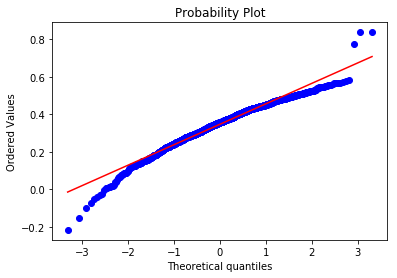

In [17]:
# TODO: Show QQ-plot
from scipy import stats
stats.probplot(results.predict(X_pred), dist="norm", plot=plt)
plt.show()

If the observations come from a normal distribution we would expect the observed order statistics to be reasonably close to the rankits or expected order statistics. In particular, if we plot the order statistics versus the rankits we should get approximately a straight line.

The Q-Q plot comes very close to a straight line, except possibly for the upper tail, where we find a couple of residuals somewhat larger than expected.

In general, Q-Q plots showing curvature indicate skew distributions, with downward concavity corresponding to negative skewness and upward concavity indicating positive skewness. 

### Task 2: Residual Plot
Now evaluate your fit by plotting the residuals. What does the result tell you regarding your fit? Don't write more than 4 sentences.

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'Residual plot')

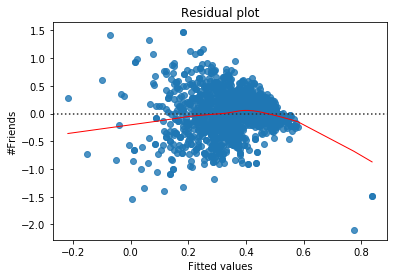

In [25]:
# TODO: Plot standardized residuals
import seaborn as sns
sns.residplot(rst.reshape(-1),'#Friends', data=X_pred,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

Residual plot is used to validate the assumption of linearity, by drawing a scatter plot between fitted values and residuals.

If the plot depicts any specific or regular pattern then it is assumed the relation between the target variable and predictors is non-linear in nature i.e. non-linearity exists. 

And no pattern in the curve is a sign of linearity among the selected features and the target variable.